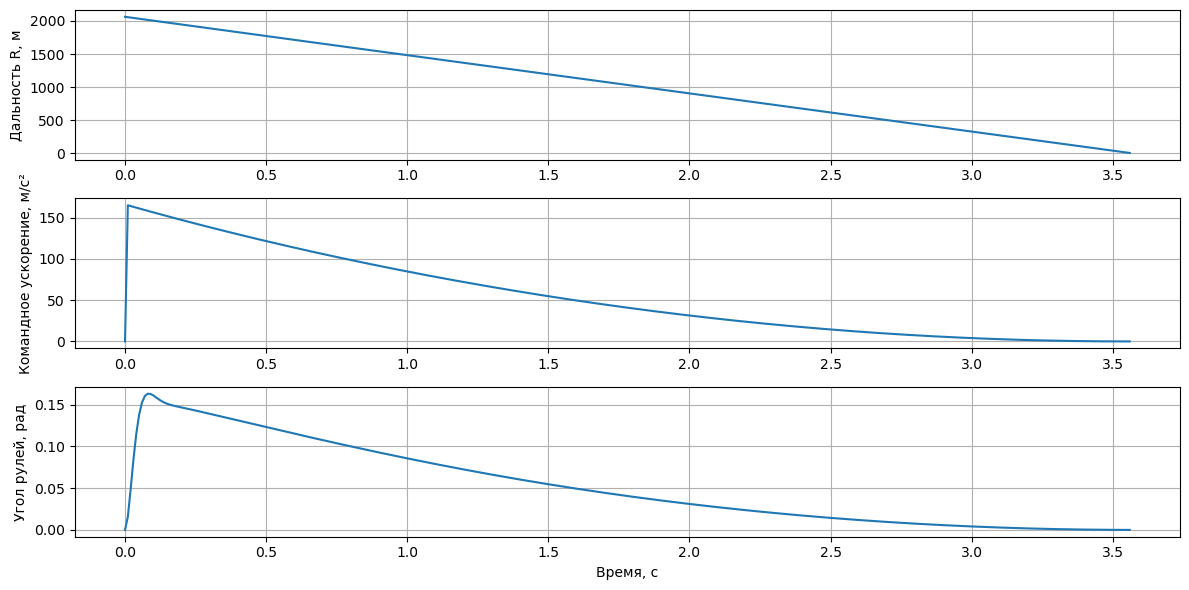

In [17]:

import numpy as np
import matplotlib.pyplot as plt

# ===== параметры моделирования =====
dt = 0.01      # шаг интегрирования, с
t_max = 20.0   # длительность моделирования, с
N_pn = 4.0     # навигационная константа
a_max = 30.0*9.81  # максимальное поперечное ускорение ракеты, м/с²

# параметры рулевого привода (2-го порядка)
wn = 50.0      # частота, рад/с
zeta = 0.7     # демпфирование

# ракета (масса и аэродинамика — упрощенные)
m_missile = 50.0  # кг

# начальные условия
r_m = np.array([0.0, 0.0, 0.0])     # позиция ракеты
v_m = np.array([300.0, 0.0, 0.0])   # скорость ракеты

# цель движется прямолинейно
r_t = np.array([2000.0, 500.0, 0.0])   # начальная позиция цели
v_t = np.array([-100.0, 0.0, 0.0])     # скорость цели

# рулевой привод (угол в рад)
delta_cmd = 0.0
delta = 0.0
delta_dot = 0.0


# истории
time_hist, R_hist, a_cmd_hist, delta_hist = [], [], [], []

# функции ----------------------------------------

def los_and_rate(r_rel_prev, r_rel, dt):
    """Вычисляет LOS и его скорость (ортогонально LOS)"""
    R = np.linalg.norm(r_rel)
    if R < 1e-6:
        return None, None, 0.0

    u = r_rel / R
    # предыдущий LOS
    R_prev = np.linalg.norm(r_rel_prev)
    u_prev = r_rel_prev / R_prev if R_prev>1e-6 else u

    # производные через разности
    du = (u - u_prev) / dt
    du = du - np.dot(du,u)*u   # ортогонализация
    dR = (R - R_prev) / dt
    Vc = -dR                   # скорость сближения (>0 при уменьшении дальности)

    return u, du, Vc

def pn_guidance(N, Vc, du, a_max):
    """PN команда ускорения"""
    a_cmd = N * Vc * du
    norm_a = np.linalg.norm(a_cmd)

    if norm_a > a_max:
        a_cmd *= a_max/norm_a
    return a_cmd

def servo_dynamics(delta_cmd, delta, delta_dot, wn, zeta, dt):
    """Привод 2-го порядка через RK4"""
    def f(x):
        d1 = x[1]
        d2 = wn**2*(delta_cmd - x[0]) - 2*zeta*wn*x[1]
        return np.array([d1,d2])
    # интеграция
    k1 = f([delta,delta_dot])
    k2 = f([delta+0.5*dt*k1[0], delta_dot+0.5*dt*k1[1]])
    k3 = f([delta+0.5*dt*k2[0], delta_dot+0.5*dt*k2[1]])
    k4 = f([delta+dt*k3[0], delta_dot+dt*k3[1]])
    delta_new = delta + dt/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
    delta_dot_new = delta_dot + dt/6*(k1[1]+2*k2[1]+2*k3[1]+k4[1])
    return delta_new, delta_dot_new

# порог попадения
R_hit = 3.0

hit = False
t_hit = None
R_min = float('inf')
# начальные LOS
r_rel_prev = r_t - r_m

# основной цикл ------------------------------------
t = 0.0
while t <= t_max:
    # относительное положение
    r_rel = r_t - r_m

    R = np.linalg.norm(r_rel)
    R_min = min(R_min, R)

    if R <= R_hit:
        break
    # LOS и производные

    u, du, Vc = los_and_rate(r_rel_prev, r_rel, dt)
    if u is None:
        break

    # PN команда
    a_cmd = pn_guidance(N_pn, Vc, du, a_max)

    # командный угол рулей (очень просто: yaw/pitch через поперечное ускорение)
    # здесь просто одна величина delta_cmd ~ проекция a_cmd на ось Y корпуса
    # для учебного примера считаем корпус совпадает с осью X скорости
    a_lat = a_cmd - np.dot(a_cmd, v_m/np.linalg.norm(v_m))*(v_m/np.linalg.norm(v_m))
    delta_cmd = 0.001*np.linalg.norm(a_lat)  # масштаб условный

    # обновляем привод рулей
    delta, delta_dot = servo_dynamics(delta_cmd, delta, delta_dot, wn, zeta, dt)

    # примитивная динамика ракеты: dv = a_cmd*dt, без учета аэродинамики
    v_m += a_cmd*dt
    r_m += v_m*dt

    # цель движется равномерно
    r_t += (v_t + v_t*2)*dt 

    # история
    time_hist.append(t)
    R_hist.append(np.linalg.norm(r_rel))
    a_cmd_hist.append(np.linalg.norm(a_cmd))
    delta_hist.append(delta)

    # перенос LOS
    r_rel_prev = r_rel.copy()
    t += dt

# графики ------------------------------------------
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(time_hist, R_hist)
plt.ylabel("Дальность R, м"); plt.grid(True)

plt.subplot(3,1,2)
plt.plot(time_hist, a_cmd_hist)
plt.ylabel("Командное ускорение, м/с²"); plt.grid(True)

plt.subplot(3,1,3)
plt.plot(time_hist, delta_hist)
plt.ylabel("Угол рулей, рад"); plt.xlabel("Время, с"); plt.grid(True)

plt.tight_layout()
plt.show()
